# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started March 2021  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [60]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

import time as timestamp 

In [61]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
import LIM_plot_kb as plotkb

In [62]:
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [63]:
import importlib
importlib.reload(limkb)
importlib.reload(statskb)

<module 'LIM_stats_kb' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_stats_kb.py'>

In [64]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [65]:
full_names = {'tas':'Surface air temperature',
              'psl':'Sea level Pressure',
              'sic':'Sea ice concentration', 
              'sit':'Sea ice thickness',
              'tos':'Sea surface temperature',
              'zg': '500hPa geopotential height'}

areawt_name = {'tas':'areacella',
               'psl':'areacella',
               'sic':'areacello', 
               'sit':'areacello',
               'tos':'areacello',
               'zg': 'areacella'}

month_names = ['January','Februrary','March','April','May','June','July','August',
               'September','October','November','December']

In [66]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [67]:
import warnings
warnings.filterwarnings("ignore")

In [104]:
#folder = 'L_tas_tos_sic_mpilm_ntrunc400_nmodes60_nmodessic_50_ntrain_2000_032321'
folder = 'L_tas_tos_sic_mpilm_ntrunc400_nmodes60_nmodessic50_ntrain600_20210405'

# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 60 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

mo=0

# forecast lead time in months that defines the LIM training
tau = 1

ntrain = 0.6

limvars = ['tas','tos','sic']
limvars_nosic = ['tas','tos']

nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm_kb'
#train_dsource = 'ccsm4_lm_kb'
valid_dsource = 'mpi_lm_kb'
#valid_dsource = 'ccsm4_lm_kb'

sic_separate = True

prebuilt_months = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#prebuilt_months = [0,1]

In [69]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_ccsm4 = limkb.build_training_dic(train_dsource)
fdic_mpi = limkb.build_training_dic(valid_dsource)

In [70]:
areacell = {}
areacella_dict = {}
areacell['areacella'], areacella_dict = limkb.load_data('areacella', areacella_dict, fdic_ccsm4, 
                                                  remove_climo=False, detrend=False, verbose=False)

areacello_dict = {}
areacell['areacello'], areacello_dict = limkb.load_data('areacello', areacello_dict, fdic_ccsm4, 
                                                  remove_climo=False, detrend=False, verbose=False)

areacell_dict = {}
areacell_dict['areacello'] = areacello_dict
areacell_dict['areacella'] = areacella_dict

## Load pre-build L: 

In [76]:
nmonths = len(prebuilt_months)
LIMd2_allmo= {}
var_dict_allmo= {}
W_allmo= {}
W_valid_allmo= {}
E3_allmo = {}
standard_factor_allmo = {}

for m,mo in enumerate(prebuilt_months):
    print('Working on month: '+str(mo))
    var_nms = [l+'_' for l in limvars]
    savename = ('L_mo'+str(mo)+'_'+''.join(var_nms)+ 'ntrunc'+str(ntrunc)+
                '_nmodes'+str(nmodes)+'_nmodessic'+str(nmodes_sic)+'_ntrain600_20210406.pkl')
    print('...Loading '+savename)
    
    LIM_save = pickle.load(open(folder +'/'+savename, "rb" ) )
    
    if m == 0: 
        P_train_valid_allmo = np.zeros((nmonths,LIM_save['P_train_valid'].shape[0],
                                        LIM_save['P_train_valid'].shape[1]))
        P_train_valid_allmo2 = np.zeros((nmonths,LIM_save['P_train_valid2'].shape[0],
                                        LIM_save['P_train_valid2'].shape[1]))
        P_train_allmo = np.zeros((nmonths,LIM_save['P_train'].shape[0],LIM_save['P_train'].shape[1]))
        E_allmo = np.zeros((nmonths,LIM_save['E'].shape[0],LIM_save['E'].shape[1]))
        E_sic_allmo = np.zeros((nmonths,LIM_save['E_sic'].shape[0],LIM_save['E_sic'].shape[1]))
        E_valid_allmo = np.zeros((nmonths,LIM_save['E_valid'].shape[0],LIM_save['E_valid'].shape[1]))
        E_sic_valid_allmo = np.zeros((nmonths,LIM_save['E_sic_valid'].shape[0],
                                      LIM_save['E_sic_valid'].shape[1]))
        E_valid_allmo2 = np.zeros((nmonths,LIM_save['E_valid'].shape[0],LIM_save['E_valid'].shape[1]))
        E_sic_valid_allmo2 = np.zeros((nmonths,LIM_save['E_sic_valid'].shape[0],
                                      LIM_save['E_sic_valid'].shape[1])) 
        
    LIMd2_allmo[mo] = LIM_save['LIMd2']
    var_dict_allmo[mo] = LIM_save['var_dict']
    P_train_valid_allmo[mo,:,:] = LIM_save['P_train_valid']
    P_train_valid_allmo2[mo,:,:] = LIM_save['P_train_valid2']
    P_train_allmo[mo,:,:] = LIM_save['P_train']
    E_allmo[mo,:,:] = LIM_save['E'] 
    E_valid_allmo[mo,:,:] = LIM_save['E_valid']
    E_valid_allmo2[mo,:,:] = LIM_save['E_valid2']
    E_sic_allmo[mo,:,:] = LIM_save['E_sic']  
    E_sic_valid_allmo[mo,:,:] = LIM_save['E_sic_valid']
    E_sic_valid_allmo2[mo,:,:] = LIM_save['E_sic_valid2']
    W_allmo[mo] = LIM_save['W_all']
    W_valid_allmo[mo] = LIM_save['W_all_valid']
    E3_allmo[mo] = LIM_save['E3']
    standard_factor_allmo[mo] = LIM_save['standard_factor']

Working on month: 0
...Loading L_mo0_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 1
...Loading L_mo1_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 2
...Loading L_mo2_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 3
...Loading L_mo3_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 4
...Loading L_mo4_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 5
...Loading L_mo5_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 6
...Loading L_mo6_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 7
...Loading L_mo7_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 8
...Loading L_mo8_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_ntrain600_20210406.pkl
Working on month: 9
...Loading L_mo9_tas_tos_sic_ntrunc400_nmodes60_nmode

## Prep validation data: 

In [86]:
def step1_projection_validation_var(X_train, E3, standard_factor, W): 
    """
    """
    if len(W.shape)<2:
        W_new = W[:,np.newaxis]
    else: 
        W_new = W
    eofs_out = E3/standard_factor
    # projection
    P_var = np.matmul(eofs_out.T,W_new*np.nan_to_num(X_train))

    Ptrunc = P_var/standard_factor
        
    return Ptrunc

In [116]:
X_valid.shape, nyears_train, X_t.shape

((56320, 600), 400, (56320, 1000, 12))

In [138]:
E3_allmo[mo]['tas'].shape, E_sic_valid2.shape, E3_all_valid2.shape, E_valid2.shape

((18432, 400), (56320, 50), (74752, 800), (74752, 60))

In [122]:
for mo in prebuilt_months:
    wt=True
    var_dict = {}
    tot_var_valid = {}
    tot_var_eig_valid = {}
    W_all_valid = {}
    E3_valid = {}
    Ptrunc_valid2 = {}
    standard_factor_valid = {}

    n=0

    for k, var in enumerate(limvars): 
        X_var, var_dict = limkb.load_data(var, var_dict, fdic_ccsm4, remove_climo=True, 
                                          detrend=True, verbose=True)

        tsamp = X_var.shape[1]
        nyears_valid = int((tsamp*(1-ntrain))/12)

        X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
        X_valid = X_t[:,-nyears_train:,mo]

        Ptrunc_valid2[var] = step1_projection_validation_var(X_valid, E3_allmo[mo][var], 
                                                             standard_factor_allmo[mo][var], 
                                                             W_allmo[mo][var])
        del X_var


    ndof_all_valid = limkb.count_ndof_all(limvars, E3_allmo[mo], sic_separate=sic_separate)

    [Ptrunc_all_valid2, E3_all_valid2,
     Ptrunc_sic_valid2,
     E_sic_valid2] = limkb.stack_variable_eofs(limvars, ndof_all_valid, ntrunc, Ptrunc_valid2, E3_allmo[mo], 
                                               var_dict_allmo[mo], sic_separate=sic_separate)

    [P_train_valid2, Fvar_valid2, 
     E_valid2] = limkb.step2_multivariate_compress(Ptrunc_all_valid2,nmodes, E3_all_valid2, Ptrunc_sic_valid2,
                                                  sic_separate=sic_separate)

    LIM_train_save = {}
    LIM_train_save['E_valid2'] = E_valid2
    LIM_train_save['E_sic_valid2'] = E_sic_valid2
    LIM_train_save['P_train_valid2'] = P_train_valid2


    var_nms = [l+'_' for l in limvars]
    savename = ('Validation_data_mo'+str(mo)+'_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+'_nmodes'+str(nmodes)+
                '_nmodessic'+str(nmodes_sic)+'_nvalid'+str(nyears_valid)+'_'+today_date+'.pkl')
    pickle.dump(LIM_save, open(savename, "wb" ) )

    print('Saving to: '+savename)



Loading tas
removing climotology...
detrending...
(18432, 12000)
(18432, 12000)
-----------------------------------------------------
completed in 32.07142400741577 seconds
-----------------------------------------------------
Loading tos
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 97.30854082107544 seconds
-----------------------------------------------------
Loading sic
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 153.45784783363342 seconds
-----------------------------------------------------
Fraction in first 60 multivariate EOFs = 82.89097091074693
Shape of E: (74752, 60)
Saving to: Validation_data_mo0_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Loading tas
removing climotology...
detrending...
(18432, 12000)
(18432, 12000)
-----------------------------------------------------
comp

Loading sic
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 146.22100281715393 seconds
-----------------------------------------------------
Fraction in first 60 multivariate EOFs = 79.70331596263706
Shape of E: (74752, 60)
Saving to: Validation_data_mo9_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Loading tas
removing climotology...
detrending...
(18432, 12000)
(18432, 12000)
-----------------------------------------------------
completed in 32.931434869766235 seconds
-----------------------------------------------------
Loading tos
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 93.69616031646729 seconds
-----------------------------------------------------
Loading sic
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
com

### Load prepared validation data: 

In [123]:
E_valid2.shape, P_train_valid2.shape, E_sic_valid2.shape

((74752, 60), (110, 400), (56320, 50))

In [124]:
nmonths = len(prebuilt_months)

for m,mo in enumerate(prebuilt_months):
    print('Working on month: '+str(mo))
    var_nms = [l+'_' for l in limvars]
    savename = ('Validation_data_mo'+str(mo)+'_'+ ''.join(var_nms)+ 'ntrunc'+str(ntrunc)+'_nmodes'+str(nmodes)+
                '_nmodessic'+str(nmodes_sic)+'_nvalid400_20210407.pkl')
    print('...Loading '+savename)
    
    LIM_save = pickle.load(open(folder +'/'+savename, "rb" ) )
    
    if m == 0: 
        E_valid_allmo2 = np.zeros((nmonths,LIM_train_save['E_valid2'].shape[0],
                                   LIM_train_save['E_valid2'].shape[1]))
        P_train_valid_allmo2 = np.zeros((nmonths,LIM_train_save['P_train_valid2'].shape[0],
                                         LIM_train_save['P_train_valid2'].shape[1]))
        
    E_valid_allmo2[mo,:,:] = LIM_train_save['E_valid2']
    P_train_valid_allmo2[mo,:,:] = LIM_train_save['P_train_valid2']

Working on month: 0
...Loading Validation_data_mo0_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Working on month: 1
...Loading Validation_data_mo1_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Working on month: 2
...Loading Validation_data_mo2_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Working on month: 3
...Loading Validation_data_mo3_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Working on month: 4
...Loading Validation_data_mo4_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Working on month: 5
...Loading Validation_data_mo5_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Working on month: 6
...Loading Validation_data_mo6_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Working on month: 7
...Loading Validation_data_mo7_tas_tos_sic_ntrunc400_nmodes60_nmodessic50_nvalid400_20210407.pkl
Working on month: 8
...Loading Validation_data_mo8_tas_tos_sic_n

In [125]:
LIM_train_save['P_train_valid2'].shape

(110, 400)

## Run Forecast: 

In [126]:
P_train_valid_allmo.shape, P_train_valid_allmo2.shape

((11, 110, 400), (11, 110, 400))

In [128]:
lags = [0,1]

ntims = len(lags)

for m,mo in enumerate(prebuilt_months):
    print('Month '+ str(mo)+' of '+str(nmonths-1))
    P_train_2d = np.reshape(P_train_allmo[mo,:,:], (P_train_allmo.shape[1],int(P_train_allmo.shape[2]/2),2))
    
#    LIM_fcast = limkb.LIM_forecast_Gt(LIMd2_allmo[mo],P_train_2d[:,:,0],lags)
    LIM_fcast = limkb.LIM_forecast_Gt(LIMd2_allmo[mo],P_train_valid_allmo[mo,:,:],lags)
    
    x_forecast_dcomp = np.zeros((len(lags),(LIM_save['E'].shape[0]+LIM_save['E_sic'].shape[0]),
                                 LIM_fcast['x_forecast'].shape[2]))

    for i,lag in enumerate(lags):
        print('Lag '+ str(lag))
          ## Decompress with training/validation eofs 
#         x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
#                                                                     nmodes,nmodes_sic,
#                                                                     E_valid_allmo[mo,:,:],
#                                                                     E_sic_allmo[mo,:,:],
#                                                                     limvars,var_dict_allmo[mo],
#                                                                     W_valid_allmo[mo],
#                                                                     sic_separate=sic_separate)
          ## Decompress with training eofs 
#         x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
#                                                                     nmodes,nmodes_sic,
#                                                                     E_allmo[mo,:,:],
#                                                                     E_sic_allmo[mo,:,:],
#                                                                     limvars,var_dict_allmo[mo],
#                                                                     W_allmo[mo],
#                                                                     sic_separate=sic_separate)
         ## Decompress with validation eofs 
        x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                                    nmodes,nmodes_sic,
                                                                    E_valid_allmo[mo,:,:],
                                                                    E_sic_valid_allmo[mo,:,:],
                                                                    limvars,var_dict_allmo[mo],
                                                                    W_valid_allmo[mo],
                                                                    sic_separate=sic_separate)
        
    if m == 0:
        x_forecast_0_dcomp = np.zeros((nmonths,LIM_save['E'].shape[0]+LIM_save['E_sic'].shape[0],
                                       LIM_fcast['x_forecast'].shape[2]))
        x_forecast_1_dcomp = np.zeros((nmonths,LIM_save['E'].shape[0]+LIM_save['E_sic'].shape[0],
                                       LIM_fcast['x_forecast'].shape[2]))

    x_forecast_0_dcomp[m,:,:] = x_forecast_dcomp[0,:,:]
    x_forecast_1_dcomp[m,:,:] = x_forecast_dcomp[1,:,:]

Month 0 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 1 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 2 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 3 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 4 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 5 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 6 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 7 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 8 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 9 of 10
t= 0
t= 1
Lag 0
Lag 1
Month 10 of 10
t= 0
t= 1
Lag 0
Lag 1


In [42]:
# for m,mo in enumerate(prebuilt_months):
    
#     x_forecast = x_forecast_1_dcomp[mo,var_dict[var]['var_inds'],:] #+ X_valid_mn[:,np.newaxis]
#     x_forecast_anom = x_forecast - np.nanmean(x_forecast,axis=1)[:,np.newaxis]

#     tot_nh_sic_forecast = statskb.calc_tot_si(x_forecast_anom, areacell[areawt_name[var]], 
#                                               units, var_dict[var]['lat'], lat_cutoff=0.0)
    
#     plt.plot(tot_nh_sic_forecast[:10])
    
# plt.show()

## Validation for 1 month lag: 

Loading sic
removing climotology...
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 171.08609223365784 seconds
-----------------------------------------------------
Month 0 of 10
Using month 0...
Truth month =  1


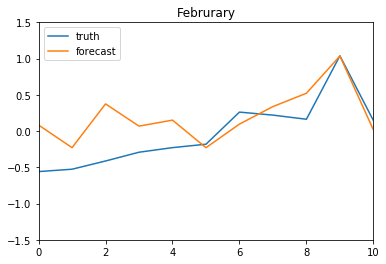

1.2088401845457644
Month 1 of 10
Using month 1...
Truth month =  2


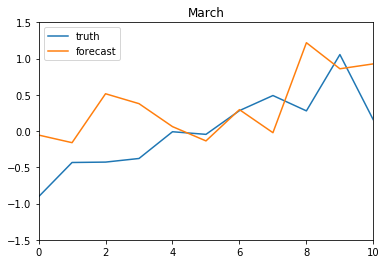

1.014353297950685
Month 2 of 10
Using month 2...
Truth month =  3


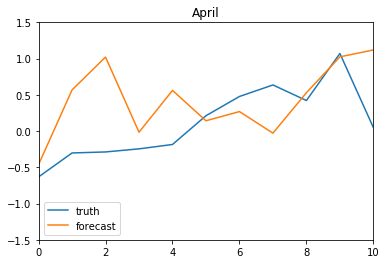

1.1965556548414529
Month 3 of 10
Using month 3...
Truth month =  4


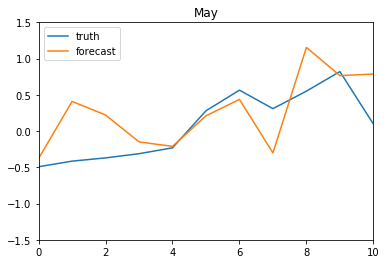

2.490834737695898
Month 4 of 10
Using month 4...
Truth month =  5


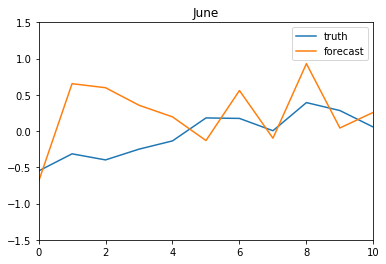

145.8690797079901
Month 5 of 10
Using month 5...
Truth month =  6


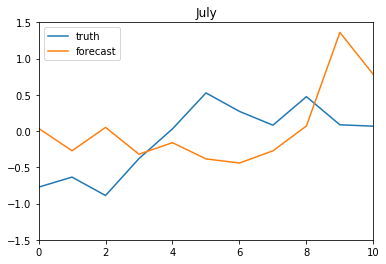

44.35977484430433
Month 6 of 10
Using month 6...
Truth month =  7


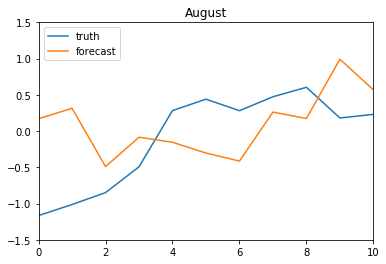

0.6832575849060334
Month 7 of 10
Using month 7...
Truth month =  8


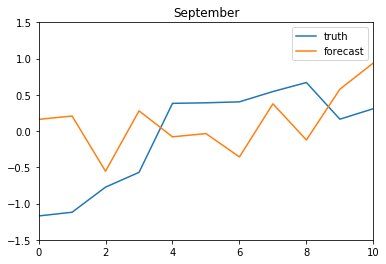

0.37319807996776694
Month 8 of 10
Using month 8...
Truth month =  9


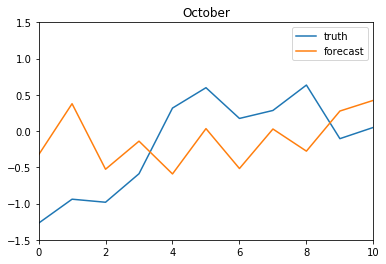

0.2893054843183748
Month 9 of 10
Using month 9...
Truth month =  10


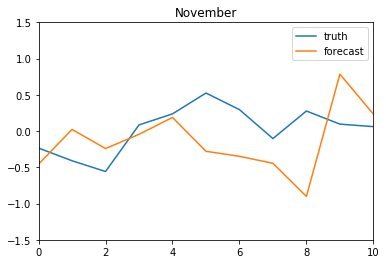

0.4688685567235146
Month 10 of 10
Using month 10...
Truth month =  11


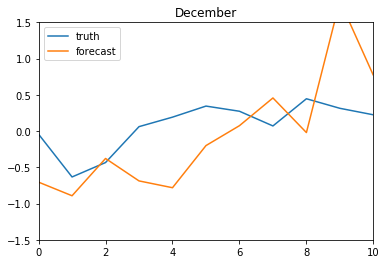

446.94889797251165


In [130]:
plot_fcast = True
lag = 1
v = {}
validvars = ['sic']
validation_stats = {}
valid_stats = {}

for k, var in enumerate(validvars): 
    corr_tot = np.zeros((len(prebuilt_months)))
    ce_tot = np.zeros((len(prebuilt_months)))
    gm_var_ratio = np.zeros((len(prebuilt_months)))

    X_var, _ = limkb.load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)

    for m,mo in enumerate(prebuilt_months):
#    for i,lag in enumerate([0]):
        print('Month '+ str(mo)+' of '+str(nmonths-1))

        x_forecast = x_forecast_1_dcomp[mo,var_dict_allmo[mo][var]['var_inds'],:] #+ X_valid_mn[:,np.newaxis]
        x_forecast_anom = x_forecast[:,lag:] - np.nanmean(x_forecast[:,lag:],axis=1)[:,np.newaxis]
        
        print('Using month '+str(mo)+'...')
        tsamp = X_var.shape[1]
        ntime_train = x_forecast.shape[1]
        nyears_train = x_forecast.shape[1]
        nyears_valid = nyears_train

        X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))

        step = mo+lag
        print('Truth month = ', str(step))
        if step>11:
            step = step-12
            start_yr = 1
        else: 
            start_yr = 0
        x_truth = X_t[:,start_yr:nyears_train-lag,step]
        x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
    
        units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
        tot_nh_sic_forecast = statskb.calc_tot_si(x_forecast_anom, areacell[areawt_name[var]], 
                                                  units, var_dict_allmo[mo][var]['lat'], 
                                                  lat_cutoff=0.0)
        tot_nh_sic_truth = statskb.calc_tot_si(x_truth_anom, areacell[areawt_name[var]], 
                                               units, var_dict_allmo[mo][var]['lat'],
                                               lat_cutoff=0.0)
        
        if plot_fcast == True: 
            plt.figure(figsize=(6,4))
            plt.plot(tot_nh_sic_truth*1e-6,label='truth')
            plt.plot(tot_nh_sic_forecast*1e-6,label='forecast')
            plt.xlim(0,10)
            plt.ylim(-1.5, 1.5)
            if mo is 'all':
                plt.title('All months')
            else:
                plt.title(month_names[mo+1])
            plt.legend()
            plt.show()

        corr_tot[m] = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
        ce_tot[m] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)

        error_var = np.nanvar(x_truth_anom-x_forecast_anom,axis=1,ddof=1)
        truth_error_var = np.nanvar(x_truth_anom,axis=1,ddof=1)
            
        gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
        gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
        
        gm_var_ratio[m]=gm_error_var/gm_truth_var
        
        print(np.var(x_forecast_anom[1060,:]))
        
    valid_stats['gm_var_ratio'] = gm_var_ratio
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
        
    validation_stats[var] = valid_stats

In [51]:
tot_nh_sic_truth.shape,tot_nh_sic_forecast.shape

((399,), (399,))

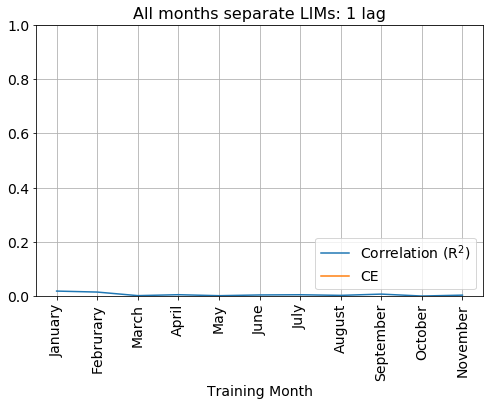

In [131]:
fig = plt.figure(figsize=(8,5))
plt.plot(valid_stats['corr_tot']**2, label='Correlation (R$^2$)')
plt.plot(valid_stats['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xticks(np.arange(0,11,1),month_names[:-1], rotation='vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='both')
plt.xlabel('Training Month', fontsize=14)
plt.title('All months separate LIMs: 1 lag', fontsize=16)
plt.legend(loc='lower right', fontsize=14)

Text(0,0.5,'GM ratio: \nerror variance to true variance')

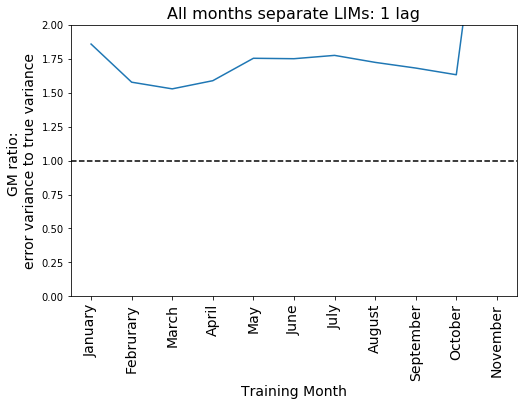

In [133]:
fig = plt.figure(figsize=(8,5))
plt.plot(valid_stats['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')
plt.xticks(np.arange(0,11,1),month_names[:-1],rotation='vertical', fontsize=14)
plt.ylim(0,2)
plt.xlabel('Training Month', fontsize=14)
plt.title('All months separate LIMs: 1 lag', fontsize=16)
plt.ylabel('GM ratio: \nerror variance to true variance', fontsize=14)

In [52]:
valid_stats['gm_var_ratio']

array([1.25455201, 1.26709449, 1.23302922, 1.35795947, 1.40306855,
       1.08867147, 2.00181425, 2.35937912, 1.21550219, 1.32765129,
       1.77480467])

In [79]:
gm_error_var/gm_truth_var

2.0945108878697005

In [60]:
LIM_fcast['x_forecast'].shape, x_forecast_dcomp.shape

((2, 110, 1000), (2, 131072, 1000))

In [ ]:
x_forecast_dcomp = np.zeros((LIM_fcast['x_forecast'].shape[0],E.shape[0]+E_sic.shape[0],
                             LIM_fcast['x_forecast'].shape[2]))

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                                nmodes,nmodes_sic,E_valid,
                                                                E_sic,limvars,var_dict,
                                                                W_all_valid,sic_separate=sic_separate)
    
#units = areacell_dict[areawt_name[var]][areawt_name[var]]['units'] 

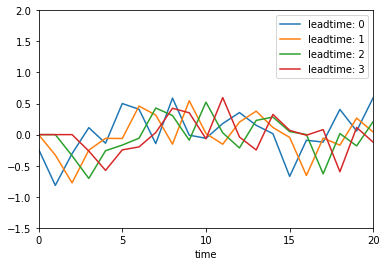

In [28]:
plt.plot(LIM_fcast['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(LIM_fcast['x_forecast'][1,0,:], label='leadtime: 1')
plt.plot(LIM_fcast['x_forecast'][2,0,:], label='leadtime: 2')
plt.plot(LIM_fcast['x_forecast'][3,0,:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.ylim(-1.5,2.0)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

In [34]:
LIM_fcast['x_forecast'][0,0,:].shape

(1000,)

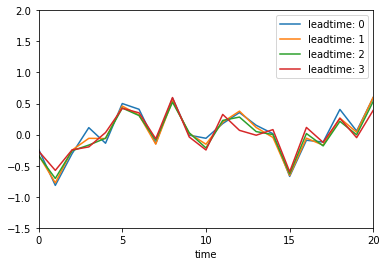

In [35]:
plt.plot(np.arange(0,1000,1),LIM_fcast['x_forecast'][0,0,:], label='leadtime: 0')
plt.plot(np.arange(0,999,1),LIM_fcast['x_forecast'][1,0,1:], label='leadtime: 1')
plt.plot(np.arange(0,998,1),LIM_fcast['x_forecast'][2,0,2:], label='leadtime: 2')
plt.plot(np.arange(0,997,1),LIM_fcast['x_forecast'][3,0,3:], label='leadtime: 3')
# plt.plot(LIM_fcast['x_forecast'][4,0,:])
#plt.plot(LIM_fcast['x_forecast'][10,0,:])
plt.xlim(0,20)
plt.xticks(np.arange(0,400,5))
plt.xlim(0,20)
plt.ylim(-1.5,2.0)
plt.xlabel('time')
plt.xlabel('time')
plt.legend()

In [58]:
x_forecast_dcomp = np.zeros((LIM_fcast['x_forecast'].shape[0],E.shape[0]+E_sic.shape[0],
                             LIM_fcast['x_forecast'].shape[2]))

for i,lag in enumerate(lags):
    print('Lag '+ str(lag))
    x_forecast_dcomp[i,:,:] = limkb.decompress_eof_separate_sic(LIM_fcast['x_forecast'][i,:,:],
                                                                nmodes,nmodes_sic,E_valid,
                                                                E_sic,limvars,var_dict,
                                                                W_all_valid,sic_separate=sic_separate)
    
#units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']                                                           W_all,Weights=True,sic_separate=sic_separate)

Lag 0
Lag 1


In [59]:
x_forecast_dcomp.shape

(2, 131072, 1000)

(0, 100)

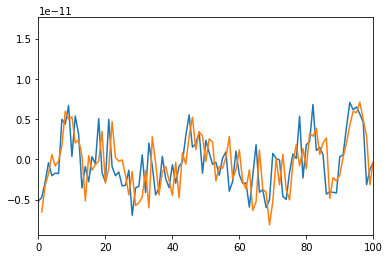

In [20]:
x_test = x_forecast_dcomp[0,var_dict['sic']['var_inds'],:]
x_test1 = x_forecast_dcomp[1,var_dict['sic']['var_inds'],:]

plt.plot(np.arange(0,600,1),x_test[0,:])
plt.plot(np.arange(1,600,1),x_test1[0,1:])
#plt.plot(np.arange(5,400,1),x_test1[0,5:])
plt.xlim(0,100)

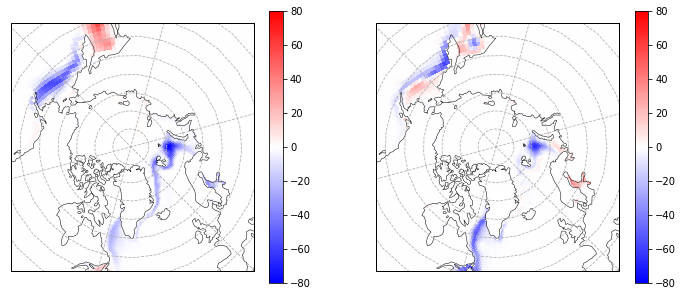

In [21]:
var = 'sic'
x_reshape = np.reshape(x_forecast_dcomp[1,var_dict[var]['var_inds'],:], (220,256,600))
x_reshape2 = np.reshape(x_forecast_dcomp[0,var_dict[var]['var_inds'],:], (220,256,600))

fig,ax = plt.subplots(1,2,figsize=(12,5), subplot_kw=arc_proj )
ax = ax.flatten()

plotkb.sub_arctic_plot(ax[0],fig,x_reshape[:,:,20],var_dict[var]['lat'],var_dict[var]['lon'],
                maxv=80,minv=-80,cmap='bwr')
plotkb.sub_arctic_plot(ax[1],fig,x_reshape2[:,:,20],var_dict[var]['lat'],var_dict[var]['lon'],
                maxv=80,minv=-80,cmap='bwr')


In [36]:
tot_nh_sic_truth.shape,tot_nh_sic_forecast.shape

((600,), (599,))

Lag 0
Using month 1...
Step = 1


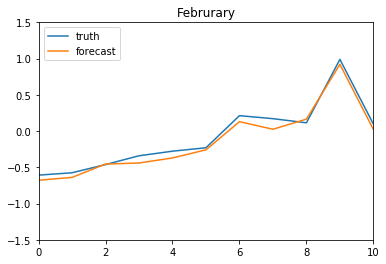

0.6915273209298033
Lag 1
Using month 1...
Step = 2


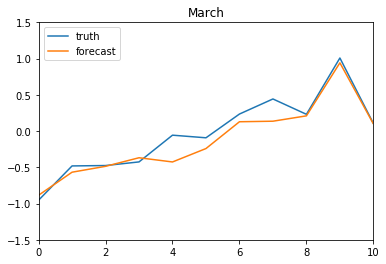

0.5179394497050321
Lag 2
Using month 1...
Step = 3


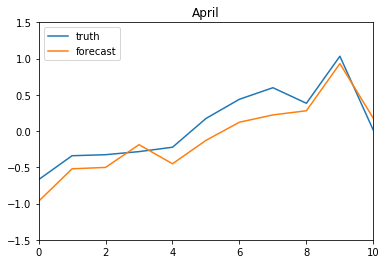

0.4339224782905609
Lag 3
Using month 1...
Step = 4


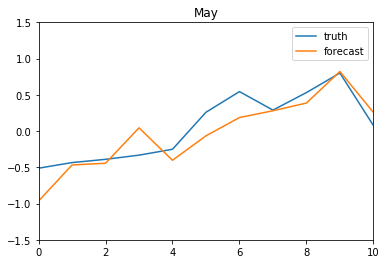

0.41723969861999805


In [38]:
v = {}
validvars = ['sic']
validation_stats = {}
valid_stats = {}

for k, var in enumerate(validvars): 
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))

#    X_var, _ = limkb.load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)

    for i,lag in enumerate(lags):
#    for i,lag in enumerate([0]):
        print('Lag '+str(lag))
        
        x_forecast = x_forecast_dcomp[lag,var_dict[var]['var_inds'],:] #+ X_valid_mn[:,np.newaxis]
        
        tsamp = X_var.shape[1]
        nyears_train = int((tsamp*ntrain)/12)
        #nyears_valid = int(X_all_mpi.shape[2]/12)
        nyears_valid = nyears_train
        ntime_train = x_forecast.shape[1]
        
        if mo is 'all':
            print('Using all months...')
            X_t = X_var
            X_valid = X_t[:,0:ntime_train]
            
            start_time = lag
            x_truth = X_t[:,start_time:ntime_train]
            x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
            
            x_forecast_new_anom = x_forecast[:,lag:] - np.nanmean(x_forecast[:,lag:],axis=1)[:,np.newaxis]
        else: 
            print('Using month '+str(mo)+'...')
            nyears_train = x_forecast.shape[1]
            #nyears_valid = int(X_all_mpi.shape[2]/12)
            nyears_valid = nyears_train

            X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
            X_valid = X_t[:,0:nyears_train:,mo]
    #    truth = X_t[:,nyears_train:,mo+1]
         
            step = mo+lag
            print('Step = '+str(step))
            if step>11:
                step = step-12
                start_yr = 1
            else: 
                start_yr = 0
            
            x_truth = X_t[:,start_yr:nyears_train-lag,step]
            x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
        
            x_forecast_new_anom = x_forecast[:,lag:] - np.nanmean(x_forecast[:,lag:],axis=1)[:,np.newaxis]
    
        units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
        tot_nh_sic_forecast = statskb.calc_tot_si(x_forecast_new_anom, areacell[areawt_name[var]], 
                                          units, var_dict[var]['lat'], lat_cutoff=0.0)
        tot_nh_sic_truth = statskb.calc_tot_si(x_truth_anom, areacell[areawt_name[var]], 
                                       units, var_dict[var]['lat'],lat_cutoff=0.0)
        
        plt.figure(figsize=(6,4))
        plt.plot(tot_nh_sic_truth*1e-6,label='truth')
        plt.plot(tot_nh_sic_forecast*1e-6,label='forecast')
        plt.xlim(0,10)
        plt.ylim(-1.5, 1.5)
        if mo is 'all':
            plt.title('All months')
        else:
            plt.title(month_names[step])
        plt.legend()
        plt.show()
        
#         if lag ==0: 
        corr_tot[i] = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
        ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)

        error_var = np.nanvar(x_truth_anom-x_forecast_new_anom,axis=1,ddof=1)
        truth_error_var = np.nanvar(x_truth_anom,axis=1,ddof=1)
#         else: 
#             corr_tot[i] = np.corrcoef(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast[lag:])[0,1]
#             ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast[lag:])

#             error_var = np.nanvar(x_truth_anom[:,:-lag]-x_forecast_new_anom[:,lag:],axis=1,ddof=1)
#             truth_error_var = np.nanvar(x_truth_anom[:,:-lag],axis=1,ddof=1)
            
        gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
        gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
        
        gm_var_ratio[i]=gm_error_var/gm_truth_var
        
        print(np.var(x_forecast_new_anom[1060,:]))
    valid_stats['gm_var_ratio'] = gm_var_ratio
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
        
    validation_stats[var] = valid_stats

Lag 0
step = 1


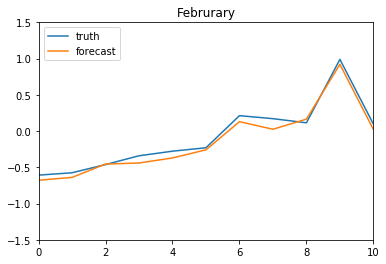

0.6915273209298033
Lag 1
step = 2


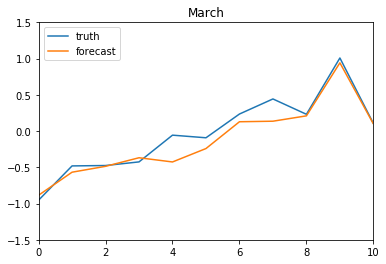

0.5179394497050321
Lag 2
step = 3


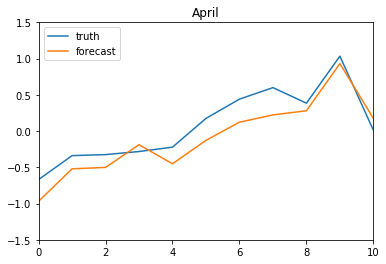

0.4339224782905609
Lag 3
step = 4


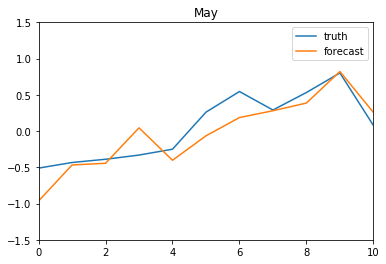

0.41723969861999805


In [66]:
v = {}
validvars = ['sic']
validation_stats = {}
valid_stats = {}

for k, var in enumerate(validvars): 
    corr_tot = np.zeros((len(lags)))
    ce_tot = np.zeros((len(lags)))
    gm_var_ratio = np.zeros((len(lags)))

#    X_var, _ = limkb.load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    mo = 1
    for i,lag in enumerate(lags):
#    for i,lag in enumerate([0]):
        print('Lag '+str(lag))
        
        x_forecast = x_forecast_dcomp[lag,var_dict[var]['var_inds'],:] #+ X_valid_mn[:,np.newaxis]
        
        tsamp = X_var.shape[1]
#        nyears_train = int((tsamp*ntrain)/12)
#         nyears_valid = int((tsamp*(1-ntrain))/12)
        nyears_train = x_forecast.shape[1]
        nyears_valid = nyears_train

        X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
        
        step = mo+lag
        print('step = '+str(step))
        if step>11:
            step = step-12
            start_yr = 0+1
        else: 
            start_yr = 0
            
        x_truth = X_t[:,start_yr:nyears_train,step]
        x_truth_anom = x_truth - np.nanmean(x_truth,axis=1)[:,np.newaxis]
        
#         if var is 'sic':
#             x_forecast_noneg = np.where(x_forecast<-100.0, -100.0, x_forecast)
#             x_forecast_new = np.where(x_forecast_noneg>100.0, 100.0, x_forecast_noneg)
#         else: 
#             x_forecast_new = x_forecast
        x_forecast_new_anom = x_forecast[:,lag:] - np.nanmean(x_forecast[:,lag:],axis=1)[:,np.newaxis]
    
        units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
        tot_nh_sic_forecast = statskb.calc_tot_si(x_forecast_new_anom, areacell[areawt_name[var]], 
                                          units, var_dict[var]['lat'], lat_cutoff=0.0)
        tot_nh_sic_truth = statskb.calc_tot_si(x_truth_anom, areacell[areawt_name[var]], 
                                       units, var_dict[var]['lat'],lat_cutoff=0.0)
        
        plt.figure(figsize=(6,4))
        plt.plot(tot_nh_sic_truth*1e-6,label='truth')
        plt.plot(tot_nh_sic_forecast*1e-6,label='forecast')
        plt.xlim(0,10)
        plt.ylim(-1.5,1.5)
        plt.legend()
        plt.title(month_names[step])
        plt.show()
        
        if lag ==0: 
            corr_tot[i] = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
            ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)

            error_var = np.nanvar(x_truth_anom-x_forecast_new_anom,axis=1,ddof=1)
            truth_error_var = np.nanvar(x_truth_anom,axis=1,ddof=1)
        else: 
            corr_tot[i] = np.corrcoef(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast)[0,1]
            ce_tot[i] = LMR_utils.coefficient_efficiency(tot_nh_sic_truth[:-lag],tot_nh_sic_forecast)

            error_var = np.nanvar(x_truth_anom[:,:-lag]-x_forecast_new_anom,axis=1,ddof=1)
            truth_error_var = np.nanvar(x_truth_anom[:,:-lag],axis=1,ddof=1)
            
        gm_error_var = statskb.global_mean(error_var,areacell[areawt_name[var]])
        gm_truth_var = statskb.global_mean(truth_error_var,areacell[areawt_name[var]])
        
        gm_var_ratio[i]=gm_error_var/gm_truth_var
        
        print(np.var(x_forecast_new_anom[1060,:]))
    valid_stats['gm_var_ratio'] = gm_var_ratio
    valid_stats['corr_tot'] = corr_tot
    valid_stats['ce_tot'] = ce_tot
        
    validation_stats[var] = valid_stats

In [69]:
x_truth.shape

(56320, 600)

(0, 10)

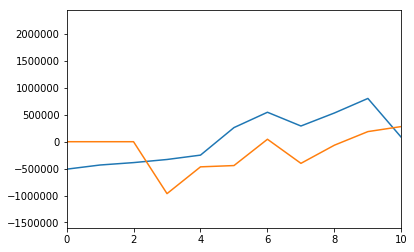

In [54]:
plt.plot(tot_nh_sic_truth)
plt.plot(tot_nh_sic_forecast)
plt.xlim(0,10)

### ^^^ Variance is not decreasing with lag at this and other gridcells? ^^^

In [174]:
start_yr, nyears_train, step

(0, 600, 4)

(0, 10)

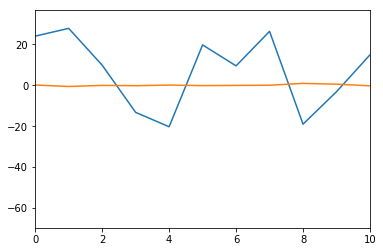

In [44]:
plt.plot(x_truth_anom[1061,:])
plt.plot(x_forecast_new_anom[1061,:])
plt.xlim(0,10)

In [40]:
x_var = x_truth
var_nans_mask = np.where(np.isnan(x_var),np.nan,1)
var_dt = spy.signal.detrend(np.where(np.isnan(x_var),0,x_var),axis=0)
x_var_dt = var_dt*var_nans_mask


In [195]:
testmn = np.nanmean(x_var_dt, axis=1)
testmn[1061]

39.180308591524756

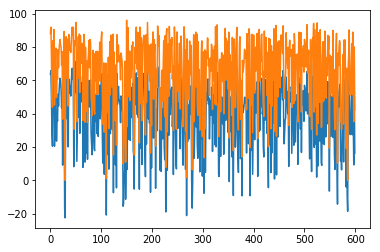

In [196]:
plt.plot(x_var_dt[1061,:])
plt.plot(x_var[1061,:])

Text(0.5,1,'Error Variance: SIC')

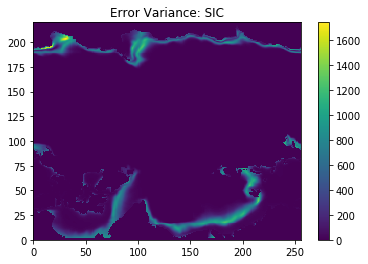

In [41]:
error_sic_2d = np.reshape(error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Error Variance: SIC')

Text(0.5,1,'Truth Variance: SIC')

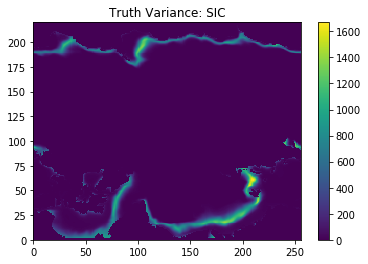

In [42]:
error_sic_2d = np.reshape(truth_error_var, (var_dict['sic']['lat'].shape))
plt.pcolormesh(error_sic_2d)
plt.colorbar()
plt.title('Truth Variance: SIC')

Text(0,0.5,'GM ratio: error variance to true variance')

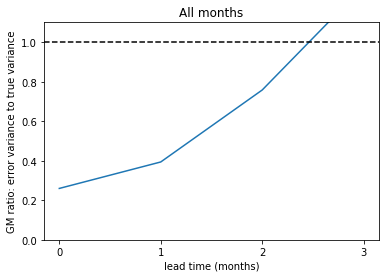

In [39]:
plt.plot(valid_stats['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')
plt.xticks([0,1,2,3])
plt.ylim(0,1.1)
plt.xlabel('lead time (months)')
plt.title('All months')
plt.ylabel('GM ratio: error variance to true variance')

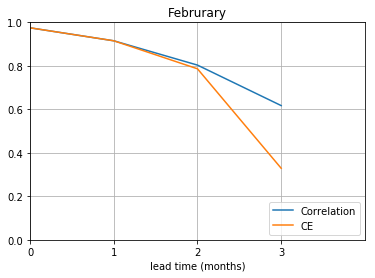

In [40]:
plt.plot(valid_stats['corr_tot']**2, label='Correlation')
plt.plot(valid_stats['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.xticks([0,1,2,3])
plt.grid(axis='both')
plt.xlabel('lead time (months)')
plt.title(month_names[mo])
plt.legend(loc='lower right')

In [24]:
P_train.shape

(110, 1200)

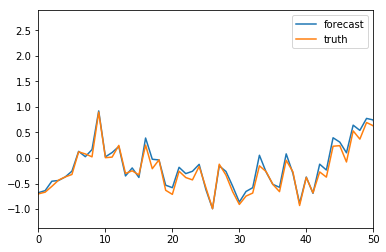

In [190]:
plt.plot(tot_nh_sic_forecast*1e-6, label='forecast')
plt.plot((tot_nh_sic_truth-np.mean(tot_nh_sic_truth,axis=0))*1e-6, label='truth')
#plt.plot(tot_nh_sic_forecast[3:]*1e-6, label='forecast')
plt.xlim(0,50)
plt.legend()

In [168]:
np.var((tot_nh_sic_truth-np.mean(tot_nh_sic_truth,axis=0))*1e-6), np.var(tot_nh_sic_forecast[1:]*1e-6)

(0.2160661, 0.3710165766249174)

In [79]:
test = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
test

0.886756258791682

In [108]:
# validvars = ['sic']
# v = {}

# for k, var in enumerate(validvars): 
#     X_var, _ = load_data(var, v, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)
    
#     mo = 1
#     tsamp = X_var.shape[1]
#     nyears_train = int((tsamp*ntrain)/12)
#     nyears_valid = int((tsamp*(1-ntrain))/12)

#     X_t = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))
#     x_truth = X_t[:,nyears_train:,mo+1]
    
#     x_forecast = x_forecast_dcomp[var_dict[var]['var_inds'],:]
    
#     units = areacell_dict[areawt_name[var]][areawt_name[var]]['units']
#     tot_nh_sic_forecast = calc_tot_si(x_forecast, areacell[areawt_name[var]], 
#                                       units, var_dict[var]['lat'], cutoff=0.0)
#     tot_nh_sic_truth = calc_tot_si(x_truth, areacell[areawt_name[var]], 
#                                    units, var_dict[var]['lat'],cutoff=0.0)
    
#     corr_tot_sic = np.corrcoef(tot_nh_sic_truth,tot_nh_sic_forecast)[0,1]
#     ce_tot_sic = LMR_utils.coefficient_efficiency(tot_nh_sic_truth,tot_nh_sic_forecast)
    
#     error_var = np.nanvar(x_forecast - x_truth,axis=1,ddof=1)
#     gm_error_var = global_mean(error_var,areacell[areawt_name[var]])
    
#     truth_error_var = np.nanvar(x_truth,axis=1,ddof=1)
#     gm_truth_var = global_mean(truth_error_var,areacell[areawt_name[var]])

Loading sic
-----------------------------------------------------
completed in 86.63140058517456 seconds
-----------------------------------------------------


In [64]:
validation_stats['sic']['gm_var_ratio'].shape, validation_stats['sic']['corr_tot'].shape, validation_stats['sic']['ce_tot'].shape

((12,), (12, 400), (12, 400))

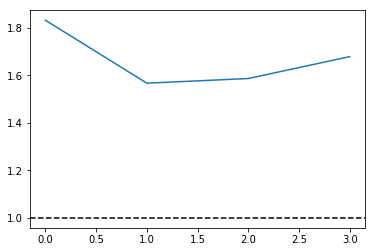

In [51]:
plt.plot(validation_stats['sic']['gm_var_ratio'])
plt.axhline(1,linestyle='--', color='k')

Text(0.5,1,'Februrary')

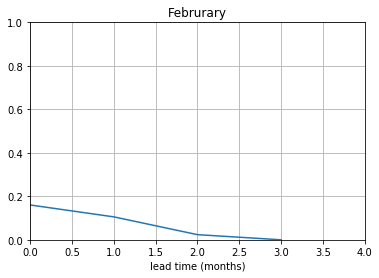

In [52]:
plt.plot(validation_stats['sic']['corr_tot']**2, label='Correlation')
plt.plot(validation_stats['sic']['ce_tot'],label='CE')
#plt.axhline(0,linestyle='--', color='k')
plt.ylim(0,1)
plt.xlim(0,4)
plt.grid(axis='both')
plt.xlabel('lead time (months)')
plt.title(month_names[mo])

In [54]:
validation_stats['sic']['corr_tot'], validation_stats['sic']['ce_tot']

(array([0.40027682, 0.32482808, 0.153841  , 0.00142255]),
 array([-0.28152417, -0.15181716, -0.48757427, -1.16456038]))

In [51]:
validation_stats['sic'].keys()

dict_keys(['gm_var_ratio', 'corr_tot', 'ce_tot'])

In [57]:
validation_stats['sic']['corr_tot'].shape

(12, 400)

In [ ]:
LIMd['G']**t

In [26]:
def arctic_mean(var, areacell, cutoff=0.0): 
    tot_nh_var = var*areacell
    if len(lat.shape)<=1:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds,:],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds,:],axis=0),axis=0)
    else:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds],axis=0),axis=0)
    
    var_mn = tot_nh_var/wt_sum
    
    return var_mn

In [27]:
def global_mean(var, areacell): 
    """Assumes var is dimensions (nlat*nlon,time)
    """
    
    tot_nh_var = var*areacell
    
    tot_var = np.nansum(tot_nh_var,axis=0)
    wt_sum = np.nansum(areacell,axis=0)
    
    var_mn = tot_var/wt_sum
    
    return var_mn

In [28]:
def calc_tot_si(var, areacell, units, lat, cutoff=0.0): 
    if units == 'm2':
        cellarea = (areacell*1e-6)[:,np.newaxis]
    else: 
        cellarea = areacell[:,np.newaxis]
        
    if var.max()>2:
        Var = var/100.0
    else: 
        Var = var
        
    nh_var = Var*cellarea
    
    if len(lat.shape)<=1:
        lat_inds = np.where(lat>cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
    else:
        lat_1d = np.reshape(lat,(var.shape[0]))
        lat_inds = np.where(lat_1d>cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
    
    return tot_nh_var
    

In [29]:
def calc_gm_polar_variance(valid_var,valid_var_mon,fields,lat,lon):
    valid_variance = {}
    gm_mon = np.zeros((12))
    polar_mon = np.zeros((2,12))
    nlat = lat.shape[0]
    nlon = lon.shape[0]

    for v in fields.keys():
        print(v)
        var = np.reshape(valid_var[fields[v]],[nlat,nlon])
        var_mon = np.reshape(valid_var_mon[fields[v],:].T,[12,nlat,nlon])

        gm,_,_ = LMR_utils.global_hemispheric_means(var,lat)
        polar = polar_regional_means(var,lat,lon)
        polar_mon = polar_regional_means(var_mon,lat,lon)
        for m in range(12):
            gm_mon[m],_,_ = LMR_utils.global_hemispheric_means(var_mon[m,:,:],lat)

        valid_variance[v+'_gm'] = gm
        valid_variance[v+'_gm_mon'] = gm_mon
        valid_variance[v+'_polarm'] = polar
        valid_variance[v+'_polarm_mon'] = polar_mon
        
    return valid_variance

In [30]:
def LIM_forecast(LIMd,x,lags):
    """
    # There is a bug with this forecast function function: It uses the eigenvectors and 
    #        values to calculate Gt, but it's giving the same value for all lags in the forecast
    
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * E: the linear map from the coordinates of the LIM to physical (lat,lon) coordinates ~(nx*ny,ndof)
    
    Outputs (in a dictionary):
    *'error' - error variance as a function of space and forecast lead time (ndof,ntims)
    *'x_forecast' - the forecast states (nlags,ndof,ntims)
    *'x_truth_phys_space' - true state in physical space (nlat*nlon,*ntims)
    *'x_forecast_phys_space' - forecast state in physical space (nlat*nlon,*ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    nx = E.shape[0]
    LIMfd = {}
    
    error = np.zeros([nx,nlags])
    x_predict_save = np.zeros([nlags,ndof,ntims])
    
    for k,t in enumerate(lags):
        print('t=',t)
        # make the propagator for this lead time
 #       Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        
        # forecast
        if t == 0:
            # need to handle this time separately, or the matrix dimension is off
            x_predict = np.matmul(Gt,x)
            x_predict_save[k,:,:] = x_predict
        else:
            x_predict = np.matmul(Gt,x[:,:-t])
            x_predict_save[k,:,t:] = x_predict

        # physical-space fields for forecast and truth for this forecast lead time ~(ndof,ntims)
#        X_predict = np.real(np.matmul(E,x_predict))
        #X_truth = np.real(np.matmul(E,x[:,t:]))
#         X_truth = truth[:,t:]
        
#         # error variance as a function of space and forecast lead time ~(ndof,ntims)
#         error[:,k] = np.var(X_predict - X_truth,axis=1,ddof=1)
    
        # return the LIM forecast error dictionary
#         LIMfd['error'] = error
        Ld = {}
        Ld['Gt'] = Gt
        LIMfd[t] = Ld
    
    LIMfd['x_forecast'] = np.squeeze(x_predict_save)    
        
    return LIMfd

In [31]:
def LIM_forecast_Gt(LIMd,x,lags):
    """
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * E: the linear map from the coordinates of the LIM to physical (lat,lon) coordinates ~(nx*ny,ndof)
    
    Outputs (in a dictionary):
    *'error' - error variance as a function of space and forecast lead time (ndof,ntims)
    *'x_forecast' - the forecast states (nlags,ndof,ntims)
    *'x_truth_phys_space' - true state in physical space (nlat*nlon,*ntims)
    *'x_forecast_phys_space' - forecast state in physical space (nlat*nlon,*ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    nx = E.shape[0]
    LIMfd = {}
    
    error = np.zeros([nx,nlags])
    x_predict_save = np.zeros([nlags,ndof,ntims])
    
    for k,t in enumerate(lags):
        print('t=',t)
        # make the propagator for this lead time
 #       Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam']*t))),LIMd['veci'])
        Gt = np.linalg.matrix_power(LIMd['G'],t)
        # forecast
        if t == 0:
            # need to handle this time separately, or the matrix dimension is off
            x_predict = np.matmul(Gt,x)
            x_predict_save[k,:,:] = x_predict
        else:
            x_predict = np.matmul(Gt,x[:,:-t])
            x_predict_save[k,:,t:] = x_predict

        Ld = {}
        Ld['Gt'] = Gt
        LIMfd[t] = Ld
    
    LIMfd['x_forecast'] = np.squeeze(x_predict_save)    
        
    return LIMfd

In [ ]:
yrs_mo = np.reshape(var_dict[var]['time'],(int(tsamp/12),12))

yrs_train = yrs_mo[0:nyears_train,mo]
yrs_valid = yrs_mo[nyears_train:,mo+1]

## EOF decomposition: 

In [ ]:
[Ptrunc, E3, Ptrunc_sic, E_sic,
 W_train, sf_train,
 tot_var, tot_var_eig] = limkb.step1_compress_individual_vars(X_train, limvars, ntrunc, 
                                                              nmodes_sic, var_dict,X_all.shape[0],
                                                              var_dict['sic']['var_ndof'], 
                                                              wt=True,sic_separate=sic_separate)


[P_train, Fvar, E] = limkb.step2_multivariate_compress(Ptrunc,nmodes, E3, Ptrunc_sic, 
                                                       sic_separate=sic_separate)

In [ ]:
[Ptrunc2, E3_2, Ptrunc_sic2, 
 E_sic2, W_train2, sf_train2] = limkb.compress_individual_vars2(X_train2, limvars, ntrunc, nmodes_sic, var_dict, 
                                                                X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                                sic_separate=sic_separate)
    
[P_train2, Fvar2, E2] = limkb.step2_multivariate_compress(Ptrunc2,nmodes, E3_2, 
                                                          Ptrunc_sic2, sic_separate=sic_separate)

In [ ]:
[Ptrunc_valid, E3_valid, Ptrunc_sic_valid, 
 E_sic_valid, W_valid, sf_valid] = limkb.compress_individual_vars2(X_valid, limvars, ntrunc, nmodes_sic, 
                                                                   var_dict,X_all.shape[0], 
                                                                   var_dict['sic']['var_ndof'], 
                                                                   sic_separate=sic_separate)

[P_valid, Fvar_valid, E_valid] = limkb.step2_multivariate_compress(Ptrunc_vlaid,nmodes, E3_valid, 
                                                                   Ptrunc_sic_valid, sic_separate=sic_separate)

In [195]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = X_all.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

x_train = P_train
x_train2 = P_train2
x_valid = P_valid

print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (60, 600)
validation data shape:  (60, 400)


In [ ]:
# x_train_dcomp = decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
#                                              limvars,var_dict,W_train,Weights=True,
#                                              sic_separate=sic_separate)

In [196]:
# # climo standardized variance for error normalization 
# #  in training and validation (1=no skill)
# # EOF space only
# if sic_separate is True: 
#     E_x_train = lim.decompress_eof_separate_sic(x_train,nmodes,nmodes_sic,E,E_sic)
#     E_x_valid = lim.decompress_eof_separate_sic(x_valid,nmodes,nmodes_sic,E_valid,E_sic_valid)

# else: 
#     E_x_train = np.matmul(E,x_train)
#     E_x_valid = np.matmul(E_valid,x_valid)

# E_x_train[np.isclose(E_x_train,0,atol=10e-10)] = np.nan
# E_x_valid[np.isclose(E_x_valid,0,atol=10e-10)] = np.nan
    
# nyrs_train = int(E_x_train.shape[1]/12)
# nyrs_valid = int(E_x_valid.shape[1]/12)
# nlalo = E_x_train.shape[0]

# # train_var_mon = np.nanvar(np.reshape(E_x_train,(nlalo,nyrs_train,12)),
# #                        axis=1,ddof=1)
# # valid_var_mon = np.nanvar(np.reshape(E_x_valid,(nlalo,nyrs_valid,12)),
# #                        axis=1,ddof=1)
# train_var = np.nanvar(E_x_train,axis=1,ddof=1)
# valid_var = np.nanvar(E_x_valid,axis=1,ddof=1)

# # FULL FIELD versions of the variance 
# train_var_full = np.nanvar(X_train,axis=1,ddof=1)
# valid_var_full = np.nanvar(X_valid,axis=1,ddof=1)

# # valid_var_mon_full = np.var(np.reshape(X_mpi,(nvars*ndof,nyrs_valid,12)),
# #                             axis=1,ddof=1)

In [49]:
# train the LIM
LIMd, G = lim.LIM_train(tau,x_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [51]:
LIMd2, G2 = lim.LIM_train_flex(tau,x_train, x_train2)

In [52]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
LIMfd_valid = lim.LIM_forecast_test(G,x_valid,lags,E_valid,truth,yrs_valid,len(limvars),ndof,
                                    nmodes=nmodes,nmodes_sic=nmodes_sic,E_sic=E_sic_valid,
                                    sic_separate=sic_separate)

t= 1


ValueError: could not broadcast input array from shape (149504) into shape (225280)

In [141]:
truth_state = {}
nlat = lat_2d[:,0].shape[0]
nlon = lon_2d[0,:].shape[0]

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        Truth = lim.decompress_eof(truth,E,E_sic=E_sic,
                                   nmodes=nmodes,nmodes_sic=nmodes_sic,
                                   sic_separate=sic_separate)
    else: 
        Truth = np.matmul(E,truth)
#            print(Truth.shape)
    truth_3d = np.reshape(Truth[fields[var],:].T,[Truth.shape[1],nlat,nlon])
    truth_gm,_,_ = LMR_utils.global_hemispheric_means(truth_3d[1:,:,:],lat_2d[:,0])
    truth_pm = lim.polar_regional_means(truth_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    truth_state[var+'_gm_mo_'+str(mo)] = truth_gm
    truth_state[var+'_pm_mo_'+str(mo)] = truth_pm
    truth_state[var+'_full_mo_'+str(mo)] = truth_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [142]:
LIMfd_valid['x_forecast'].shape

(1, 120, 1000)

In [143]:
forecast = {}

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        fcast = lim.decompress_eof(LIMfd_valid['x_forecast'][0,:,:],E,E_sic=E_sic,
                                      nmodes=nmodes,nmodes_sic=nmodes_sic,
                                      sic_separate=sic_separate)
    else: 
        fcast = np.matmul(E,LIMfd_valid['x_forecast'][0,:,:])
#            print(Truth.shape)
    forecast_3d = np.reshape(fcast[fields[var],:].T,[fcast.shape[1],nlat,nlon])
    forecast_gm,_,_ = LMR_utils.global_hemispheric_means(forecast_3d[1:,:,:],lat_2d[:,0])
    forecast_pm = lim.polar_regional_means(forecast_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    forecast[var+'_gm_mo_'+str(mo)] = forecast_gm
    forecast[var+'_pm_mo_'+str(mo)] = forecast_pm
    forecast[var+'_full_mo_'+str(mo)] = forecast_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [144]:
ce = {}
corr = {}

for n,var in enumerate(limvars):
    print('working on '+str(var))
    ce_pm_lag = np.zeros((2))
    corr_pm_lag = np.zeros((2))

    ce_gm = LMR_utils.coefficient_efficiency(truth_state[var+'_gm_mo_'+str(mo)],
                                                    forecast[var+'_gm_mo_'+str(mo)])
    corr_gm = np.corrcoef(truth_state[var+'_gm_mo_'+str(mo)],
                                 forecast[var+'_gm_mo_'+str(mo)])[0,1]

    for n in range(2):
        ce_pm_lag[n] = LMR_utils.coefficient_efficiency(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                                          forecast[var+'_pm_mo_'+str(mo)][n,:])
        corr_pm_lag[n] = np.corrcoef(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                       forecast[var+'_pm_mo_'+str(mo)][n,:])[0,1]

    ce[var+'_gm_mo_'+str(mo)] = ce_gm
    ce[var+'_pm_mo_'+str(mo)] = ce_pm_lag
    corr[var+'_gm_mo_'+str(mo)] = corr_gm
    corr[var+'_pm_mo_'+str(mo)] = corr_pm_lag

working on tas
working on psl
working on tos
working on sit
working on sic


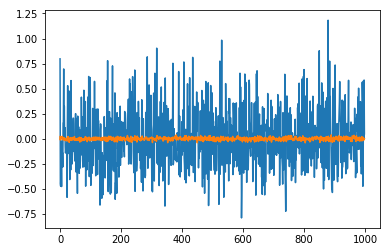

In [148]:
plt.plot(forecast['tas_gm_mo_'+str(mo)])
plt.plot(truth_state['tas_gm_mo_'+str(mo)])

In [145]:
for var in limvars: 
    print(var)
    print('GM CE = '+str(ce[var+'_gm_mo_'+str(mo)])+' GM Corr = '+ str(corr[var+'_gm_mo_'+str(mo)]))

tas
GM CE = -403.25880941645715 GM Corr = -0.024220206464738832
psl
GM CE = -741.4342540101476 GM Corr = -0.055287853100057884
tos
GM CE = -264.07100597064516 GM Corr = -0.03161414428771794
sit
GM CE = -342.94229872323535 GM Corr = -0.04336836101191847
sic
GM CE = -17.072935880843577 GM Corr = -0.019626058348466802


In [38]:
ce_ar1, corr_ar1= lim.calc_ce_corr_ar_lags(X_valid,X_train,lags,limvars,
                                           lat_2d[:,0],lon_2d[0,:])

working on tas
working on psl
working on tos
working on sic


In [39]:
ce_ar1_valid, corr_ar1_valid = lim.calc_ce_corr_ar_lags(X_valid,X_valid,lags,
                                                        limvars,lat_2d[:,0], lon_2d[0,:])

working on tas
working on psl
working on tos


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:797: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


working on sic


In [ ]:
X_valid.shape

In [ ]:
Xv.shape

In [112]:
v = 3
var = 'tos'
Xt = X_valid
Xv = X_valid
lat = lat_2d[:,0]
lon = lon_2d[0,:]
l = np.arange(1,2,1)

ar1_gm = np.zeros((len(l),Xv.shape[2]))
ar1_pm = np.zeros((len(l),2,Xv.shape[2]))
ce_pm = np.zeros((len(l),2))
corr_pm = np.zeros((len(l),2))

for i,lag in enumerate(l):
    ar1_forecast, ar1_factor = lim.red_noise_forecast_ar1(Xt[v,:].T,Xv[v,:].T,lead=lag)
    ar1_forecast_3d = np.reshape(ar1_forecast,(ar1_forecast.shape[0],nlat,nlon))
    X_valid_3d = np.reshape(Xv[v,:].T,(Xv.shape[2],nlat,nlon))
    ar1_gm[i,lag:],_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
    ar1_pm[i,:,lag:] = lim.polar_regional_means(ar1_forecast_3d,lat,lon)

    true_gm,_,_ = LMR_utils.global_hemispheric_means(X_valid_3d,lat)
    true_pm = lim.polar_regional_means(X_valid_3d,lat,lon)

    ce_gm = LMR_utils.coefficient_efficiency(true_gm[lag:],ar1_gm[i,lag:])
    corr_gm = np.corrcoef(true_gm[lag:],ar1_gm[i,lag:])[0,1]
    for n in range(2):
        ce_pm[i,n] = LMR_utils.coefficient_efficiency(true_pm[n,lag:],ar1_pm[i,n,lag:])
        corr_pm[i,n] = np.corrcoef(true_pm[n,lag:],ar1_pm[i,n,lag:])[0,1]

/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:793: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


In [122]:
np.nanmin(ar1_factor), Xv[v,:].T.shape

(-0.00033366700033366306, (12000, 3240))

In [125]:
ar1_forecast.shape

(11999, 3240)

In [106]:
corr_gm

0.9848644683160668

In [110]:
np.corrcoef(true_gm[1:],ar1_gm[0,1:])[0,1]

0.9848644683160668

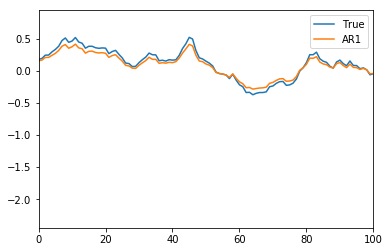

In [108]:
plt.plot(true_gm[1:], label='True')
plt.plot(ar1_gm[0,2:], label='AR1')
plt.xlim(0,100)
plt.legend()

#### check in eof space: 

In [ ]:
truth_eof = np.matmul(E_sic,x_valid_sic)
truth_eof_gm,_,_ = LMR_utils.global_hemispheric_means(np.reshape(truth_eof.T,(7212,45,72)), lat_2d[:,0])

In [ ]:
truth_state['sic_gm'].shape

In [ ]:
plt.plot(truth_state['sic_gm'][0,:],label='truth')
plt.plot(forecast['sic_gm'][0,:],label='forecast')
plt.plot(truth_eof_gm,label='truth eof')
plt.legend()
plt.title('GM SIC')

In [ ]:
k=0
ce_test = LMR_utils.coefficient_efficiency(truth_eof_gm,forecast[var+'_gm'][k,k:])
corr_test = np.corrcoef(truth_eof_gm,forecast[var+'_gm'][k,k:])[0,1]
corr_test, ce_test

In [148]:
corr_ar1_valid['tos_gm']

array([0.        , 0.98486447, 0.96391541, 0.93804171, 0.90800665,
       0.87682375, 0.84661718, 0.81847671, 0.79224612, 0.76764925,
       0.74339473, 0.71778917, 0.69008076])

## Detrending: 

In [12]:
var = 'sic'
wt=True
var_dict = {}

X_var_dt, var_dict = limkb.load_data(var, var_dict, fdic_ccsm4, remove_climo=False, 
                                     detrend=True, verbose=True)

Loading sic
detrending...
(56320, 12000)
(56320, 12000)
-----------------------------------------------------
completed in 122.32102942466736 seconds
-----------------------------------------------------


In [16]:
timei = np.arange(0,var_dict['tas']['time'].shape[0])

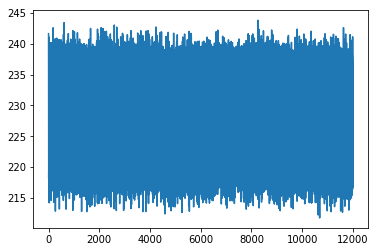

In [17]:
plt.plot(X_var[0,:])

In [ ]:
from scipy import stats 

gradient, intercept, r_value, p_value, std_err = stats.linregress(timei,X_var)

In [19]:
gradient.shape, intercept.shape

(-2.964682750653527e-05, 225.63811699611765)

In [ ]:
var = np.var(X_var[0,:])
var

In [ ]:
Y_anom = X_var - X_var.mean(axis=1)[:,np.newaxis]
X_anom = timei - timei.mean()
X_anom_mat = (X_anom * np.ones_like(Y_anom))

cov = np.dot(X_anom_mat.T,Y_anom)/(len(Y_anom)-1)
var = np.var(timei)

# a = cov/var
# b = X_var[0,:].mean() - (a)*timei.mean()

In [59]:
cov.shape

array([[-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       ...,
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5],
       [-5999.5, -5998.5, -5997.5, ...,  5997.5,  5998.5,  5999.5]])

In [13]:
def calc_linear_fit(X,Y):
    X_anom = X - X.mean()
    Y_anom = Y - Y.mean()
    
    cov = np.dot(X_anom, Y_anom)/(len(Y_anom)-1)
    var = np.var(X)
    
    slope = cov/var
    intercept = Y.mean() - slope*X.mean()
    
    return slope, intercept 

In [14]:
def linear_detrend(X,Y,remove_mn=False):
    slope, intercept = calc_linear_fit(X,Y)
    
    lin_fit = X*slope + intercept 
    
    Y_dt = Y - lin_fit
    
    if remove_mn is False: 
        Y_dt_out = Y_dt + intercept
    else: 
        Y_dt_out = Y_dt 
        
    return Y_dt_out, slope, intercept 

In [30]:
def multi_linear_detrend(X,Y,axis=1,remove_mn=False):
    """
    axis = dimension which to detrend over. 
    """
    if len(Y.shape)>2:
        raise ValueError('Too many dimensions in Y.')
    elif len(Y.shape)<2:
        Y_dt_out, slopes, intercepts = linear_detrend(X,Y,remove_mn=remove_mn)
        
        return Y_dt_out, slopes, intercepts 
    else: 
        Y_dt_out = np.zeros_like(Y)
        slopes = np.zeros(Y.shape[0])
        intercepts = np.zeros(Y.shape[0])
        
        if axis==1: 
            dt_axis=0
        else: 
            dt_axis=1

        for i in range(Y.shape[dt_axis]):
            Y_dt_out[i,:], slopes[i], intercepts[i] = linear_detrend(X,Y[i,:],remove_mn=remove_mn)
            
        return Y_dt_out, slopes, intercepts

In [24]:
Y_dt_out, slope, intercept = multi_linear_detrend(timei,X_var,axis=1,remove_mn=False)

NameError: name 'timei' is not defined

In [25]:
var_dict[var]['time'].shape[0]

12000

In [31]:
var_nans_mask = np.where(np.isnan(X_var),np.nan,1)
Y = np.where(np.isnan(X_var),0,X_var)
X = np.arange(0,var_dict[var]['time'].shape[0],1)
[var_dt,slopes,intercepts] = multi_linear_detrend(X,Y,axis=1,remove_mn=False)
x_var_dt = var_dt*var_nans_mask

In [13]:
t = 1060

slopes[t]

NameError: name 'slopes' is not defined

(11900, 12000)

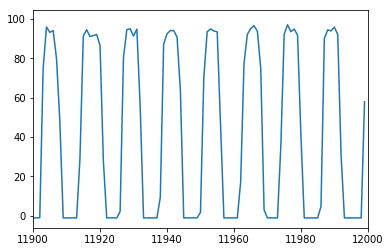

In [17]:
#plt.plot(X_var[t,:])
#plt.plot(X*slopes[t]+intercepts[t])
#plt.plot(x_var_dt[t])
plt.plot(X_var_dt[t])
plt.xlim(11900,12000)

(11900, 12000)

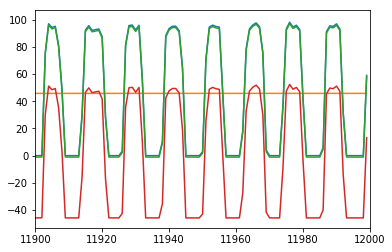

In [40]:
plt.plot(X_var[t,:])
plt.plot(X*slopes[t]+intercepts[t])
plt.plot(x_var_dt[t])
plt.plot(X_var_dt[t])
plt.xlim(11900,12000)

In [45]:
(slopes)

array([0., 0., 0., ..., 0., 0., 0.])

(0, 20)

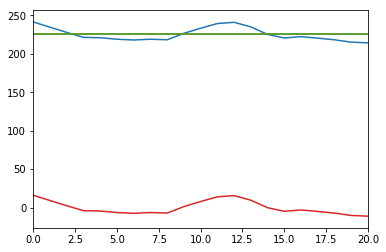

In [45]:
plt.plot(X_var[0,:])
plt.plot(timei*a+b)
plt.plot(timei*gradient+intercept)
plt.plot(Y_dt_out)
plt.xlim(0,20)

(0, 20)

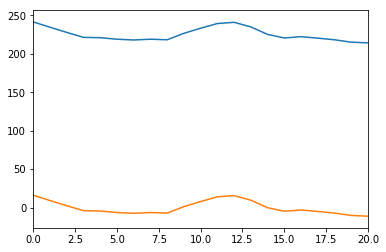

In [38]:
plt.plot(X_var[0,:])
plt.plot(Y_dt_out)
plt.xlim(0,20)